In [1]:
#Here we review techniquers for optimizing and initialising neural networks ,as we increase the depth of our networks
#face a variety of issues. Need a stable gradient flow

import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/var/folders/1q/q1xm4z_j5cgdswpvb5n90pc00000gn/T/ipykernel_14861/861492442.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
dataset_path="/Users/joesh/Documents/transformers/data"
model_path="/Users/joesh/Documents/transformers/models"

device=torch.device('cpu') if not torch.backends.mps.is_available() else torch.device('mps')
print(device)

mps


In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(model_path, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(model_path, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.2861, ),(0.3530,)) #mean and std parameter passed in as following
                                                  ]) #if greyscale may be three

train_dataset=FashionMNIST(root=dataset_path, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader=data.DataLoader(dataset=train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader=data.DataLoader(dataset=val_set, batch_size=1024, shuffle=False, drop_last=False)

test_set=FashionMNIST(root=dataset_path, train=False, transform=transform, download=True)

test_loader=data.DataLoader(dataset=test_set, batch_size=1024, shuffle=False, drop_last=False)

In [5]:
#Comparative to the previo0us tutorial we have changed the normalisation transformation transform.Normalize
#Normlization parameter expected to give a mean of 0 and a std of 1 across pixels. 

print("Mean", (train_dataset.data.float()/255.0).mean().item())
print("Std", (train_dataset.data.float()/255.0).std().item())

Mean 0.28604063391685486
Std 0.3530242443084717


In [6]:
next(iter(train_loader))

[tensor([[[[-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.1773,  0.0227, -0.6883],
           [-0.8105, -0.8105, -0.8105,  ..., -0.3994, -0.5105, -0.5772],
           ...,
           [-0.2883, -0.1550, -0.1328,  ...,  1.1114, -0.8105, -0.8105],
           [-0.7994, -0.6883, -0.6216,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105]]],
 
 
         [[[-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           ...,
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
           [-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105]]],
 
 
         [[[-0.8105, -0.8105, -0.8105,  ..., -0.8105, -0.8105, -0.8105],
       

In [7]:
imgs, _label= next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

#Min and max are not 1 and -1 anymore but are instead shifted towards positive parameters

Mean: -0.006
Standard deviation: 1.002
Maximum: 2.022
Minimum: -0.810


In [8]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=1024, num_classes=10, hidden_size=[512,256,256,128]):
        super().__init__()
        
        layers=[]
        layer_sizes= [input_size]+hidden_size
        for layer in range(1, len(layer_sizes)):
            layers+= [nn.Linear(layer_sizes[layer-1], layer_sizes[layer]), act_fn]
            
        layers+=[nn.Linear(layer_sizes[-1], num_classes)]
        self.layers=nn.ModuleList(layers) #a module list references a list of modules as submodules
        
        self.config={"act_fn": act_fn.__class__.__name__, "input_size":input_size, "hidden_layers": hidden_size,
                    "output_size":num_classes}
     
    def foward(self, x):
        x=x.view(x.size(0),-1)  #infer this dimension giving the other has been specified
        for l in self.layers:
            x=l(x)
        return x

In [9]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

model=BaseNetwork(act_fn=Identity()).to(device)

In [10]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data_fill(c)

In [11]:
#only first and last layer have diverse gradient distributions whilst the other three layers have the same gradient
#for all the weights. Having the same gradients will mean we will have same values for each parameter

#CONSTANT VARIANCE
#initialise parameters by randomly sampliong from a distribution such as a Gaussian choose one variance thart is used for layers

def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)

#variance becomes smaller and smaller across layers almost vanishing by the last layer


In [12]:
#Try and find optimum initialisation - two requirements

#mean of activations should be zero
#variance should be same across every layer.
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith('.bias'):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1/math.sqrt(param.shape[1]))

equal_var_init(model)
    

In [13]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith('.bias'):
            param.data.fill_(0)
        else:
            bound=(math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1]))
            param.data.uniform_(-bound, bound)
            
xavier_init(model)

In [14]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)

In [15]:
def attempt_load(weights, device=None, inplace=True, fuse=True):
     # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
     from models.yolo import Detect, Model

     # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
     model = Ensemble()
     for w in weights if isinstance(weights, list) else [weights]:
         ckpt = torch.load(attempt_download(w), map_location=device)
         ckpt = (ckpt.get('ema') or ckpt['model']).float()  # FP32 model
         ckpt = torch.load(attempt_download(w), map_location='cpu')  # load
         ckpt = (ckpt.get('ema') or ckpt['model']).to(device).float()  # FP32 model
         model.append(ckpt.fuse().eval() if fuse else ckpt.eval())

In [16]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [17]:
def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    file_exists=os.path.isfile(_get_model_file(model_path, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(model_path, model_name), "r") as f:
            results=json.load(f)
    else:
        if file_exists:
            print("Model file exists but will be overwritten")
            
        optimizer=optim_func(net.parameters())
        loss_module=nn.CrossEntropyLoss()
        train_loader_loc=data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        
        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)
            
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, model_path, model_name)
                best_val_epoch = epoch
        
    if results is None:
        load_model(model_path, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            son.dump(results, f)
                
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results

                               
def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc                        

In [18]:
#function zer grad sets the gradients of all parameters to zero, which we have to do prior to calling loss backward
#step() update all weights based on their gradient

#template shown below

class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params=list(params)
        self.lr=lr
    
    def zero_grad(self):
        #set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                continue
            self.update_param(p)
            
        def update_parameter(self, p):
            #to be implemented in optimizer specific classes
            raise NotImplemenentedError
                

In [19]:
class SGD(OptimizerTemplate):
    
    def __init__(self, params, lr):
        super().__init__()
    
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph
        

In [20]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum=momentum
        self.param_momentum={p:torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)
        

In [21]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr, epsilon=1e-8 ,beta1=0.9, beta2=0.99 ):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)
        

In [22]:
base_model=BaseNetwork(act_fn=nn.ReLU(), hidden_size=[512,256,256,128])
kaiming_init(base_model)

Model file of "FashionMNIST_SGD" already exists. Skipping training...


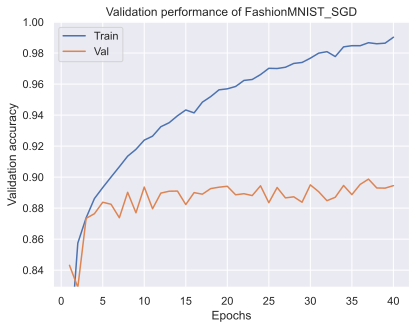

============= Test accuracy: 89.09% ==============



In [23]:
SGD_model=copy.deepcopy(base_model).to(device)
SGD_results=train_model(SGD_model, "FashionMNIST_SGD",
                       lambda params:  SGD(params, lr=1e-1),
                       batch_size=256, max_epochs=40)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


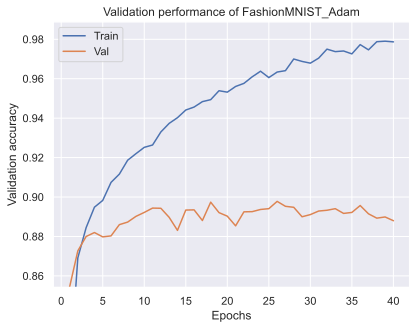

============= Test accuracy: 89.46% ==============



In [24]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam",
                           lambda params: Adam(params, lr=1e-3),
                           max_epochs=40, batch_size=256)